<table style="width: 100%; text-align: center; margin-left: auto; margin-right: auto;">
    <tr>
        <td><img src="../datos_ptlbp/img/mma_logo.png" alt="Ministerio del Medio Ambiente" style="width: 150px;"/></td>
        <td><img src="../datos_ptlbp/img/lbp_logo.svg" alt="Proyecto LBP" style="width: 150px;"/></td>
    </tr>
</table>

# Notebook para acceder a los servicios de almacen de datos geoespaciales de la Plataforma Tecnológica Línea de Base Pública (PTLBP)

Consta de: 

1. **INFORMACIÓN PRIMARIA**
   - Levantamientos de información en terreno por región.
2. **INFORMACIÓN SECUNDARIA**
   - Levantamiento de información ya existente en diferentes entidades.

### Usos

Apoyar como insumo a los diferentes instrumentos de ordenamiento territorial que nos permita hacer recomendaciones sobre el uso del territorio basados en la vocación del mismo. Sin duda hay zonas donde pueden instalarse ciertas industrias, pero también hay zonas ecológicamente importantes dado que poseen una rica biodiversidad y proveen servicios ecosistémicos fundamentales y que debemos resguardar.

Información de LBP puede servir como insumo para la medición física y valoración económica de nuestro Capital Natural.

LBP al aportar con información para todas las partes, podría ayudar para destrabar tacos de proyectos de inversión frenados y judicializados revitalizando la inversión y el desarrollo sostenible.

Elevar los estándares actuales.

Al contrastar la información levantada por titulares y funcionar como contraparte de éstos, esperamos que la LBP colabore en disminuir conflictos socioambientales con comunidades locales.

La información primaria y secundaria alimenta un almacén de datos que luego nos permite hacer cruces entre variables.

### Importar Librerias

In [2]:
import requests
import urllib3
import zipfile
import os
import pandas as pd
import geopandas as gpd
from xml.etree import ElementTree as ET
from IPython.display import display, HTML, YouTubeVideo
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Configuraciones para listado de datos

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Video explicativo de funciones

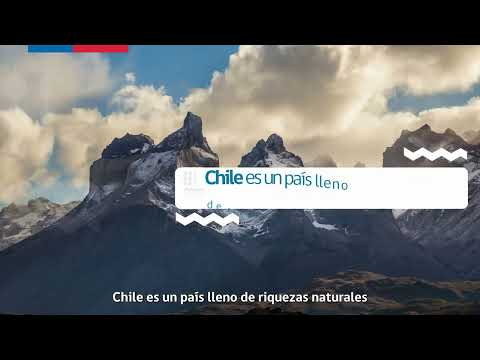

In [4]:
video_id = "yyWbmsr3dRE"
display(YouTubeVideo(video_id, width=1000, height=563))

### Dirección de servicio Web Feature Services (WFS) Institucional

In [5]:
wfs_url = 'https://lineasdebasepublicas.mma.gob.cl/geoserver/lbp/ows?service=WFS&version=1.1.0&request=GetCapabilities'

### Función para listar las capas del servicio WFS

In [6]:
def listar_capas(url):
    response = requests.get(url, verify=False)  # Asegurar que la verificación SSL utiliza certifi
    if response.status_code == 200:
        tree = ET.fromstring(response.content)
        capas = []
        namespaces = {
            'wfs': 'http://www.opengis.net/wfs',
            'ows': 'http://www.opengis.net/ows'
        }
        for el in tree.findall('.//wfs:FeatureType', namespaces):
            name = el.find('wfs:Name', namespaces).text
            title_element = el.find('ows:Title', namespaces)
            if title_element is None:
                title_element = el.find('wfs:Title', namespaces)
            title = title_element.text if title_element is not None else name
            capas.append((name, title))
        return capas
    else:
        print(f"Error al conectar con el servicio WFS: {response.status_code}")
        return []

### Funciones para mostrar catalogo de datos y descarga de datos 

In [7]:
def download_layers(selected_indices, download_format):
    selected_layers = [capas[i] for i in selected_indices]

    # Mapear los formatos a las funciones de guardado
    format_functions = {
        'GeoPackage': lambda gdf, filepath: gdf.to_file(filepath, layer=file_name_base, driver="GPKG"),
        'GeoJSON': lambda gdf, filepath: gdf.to_file(filepath, driver="GeoJSON"),
        'Shapefile': lambda gdf, filepath: save_shapefile(gdf, filepath)
    }
    # Función para guardar shapefile según geometría
    def save_shapefile(gdf, filepath):
        geom_types = gdf.geometry.type.unique()
        supported_geom_types = ['Polygon', 'MultiPolygon', 'LineString', 'MultiLineString', 'Point', 'MultiPoint']
        for geom_type in supported_geom_types:
            if geom_type in geom_types:
                gdf[gdf.geometry.type == geom_type].to_file(filepath, driver='ESRI Shapefile')
                return
        print(f"Tipo de geometría no soportado en la capa {title}: {geom_types}")
    for name, title in selected_layers:
        layer_url = f"https://lineasdebasepublicas.mma.gob.cl/geoserver/lbp/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName={name}&outputFormat=application/json"
        response = requests.get(layer_url, verify=False)
        data = response.json()
        # Convertir a GeoDataFrame
        gdf = gpd.GeoDataFrame.from_features(data['features'])
        # Comprobar y establecer CRS si no está definido
        if gdf.crs is None:
            gdf.set_crs(epsg=3857, inplace=True)
        # Reproyectar a EPSG:4326
        gdf = gdf.to_crs(epsg=4326)
        # Directorio de salida
        output_dir = os.path.expanduser('~/datos_ptlbp/productos')
        os.makedirs(output_dir, exist_ok=True)
        # Generar nombre de archivo amigable
        file_name_base = name.replace('lbp:vista_', '').replace(':', '_')
        filepath = os.path.join(output_dir, f"{file_name_base}.{download_format.lower() if download_format != 'Shapefile' else 'shp'}")
        # Guardar en el formato seleccionado
        if download_format in format_functions:
            format_functions[download_format](gdf, filepath)
        # Comprimir el archivo
        zip_filename = os.path.join(output_dir, f"{file_name_base}.zip")
        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            if download_format in ['GeoPackage', 'GeoJSON']:
                zipf.write(filepath, os.path.basename(filepath))
                os.remove(filepath)
            elif download_format == 'Shapefile':
                for ext in ['shp', 'shx', 'dbf', 'prj', 'cpg']:
                    full_path = os.path.join(output_dir, f"{file_name_base}.{ext}")
                    if os.path.exists(full_path):
                        zipf.write(full_path, os.path.basename(full_path))
                        os.remove(full_path)
        print(f"Capa {title} descargada y comprimida como {zip_filename}")

### Listado de capas disponibles

In [8]:
capas = listar_capas(wfs_url)
capas_html = """
<h3 style="font-size: 20px;">Capas disponibles:</h3>
<ul style="font-size: 18px;">
"""
for i, (name, title) in enumerate(capas):
    capas_html += f"<li>{i+1}. {title}</li>"
capas_html += "</ul>"
display(HTML(capas_html))

### Seleccione capas por número. 
### Si desea más de una capa escríbala separada de coma (",")

In [9]:
selected_indices = input("Introduce los números de las capas a seleccionar, separados por comas: ")
selected_indices = [int(i) - 1 for i in selected_indices.split(",")]

### Seleccione el formato de descarga:
### (GeoPackage, GeoJSON, Shapefile)

In [10]:
formats = {1: "GeoPackage", 2: "GeoJSON", 3: "Shapefile"}
formats_html = """
<h3 style="font-size: 20px;">Formatos disponibles:</h3>
<ul style="font-size: 18px;">
"""
for i, format_name in formats.items():
    formats_html += f"<li>{i}. {format_name}</li>"
formats_html += "</ul>"
display(HTML(formats_html))

download_format = int(input("Introduce el número del formato de descarga: "))

# Validar formato seleccionado
if download_format in formats:
    download_format_str = formats[download_format]
    # Ejecutar la descarga
    download_layers(selected_indices, download_format_str)
else:
    print("Formato no válido")

/tmp/ipykernel_19277/2330962727.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf[gdf.geometry.type == geom_type].to_file(filepath, driver='ESRI Shapefile')


Capa Parque Nacional descargada y comprimida como /home/chris/datos_ptlbp/productos/parque_nacional.zip
